In [2]:
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import pandas as pd
import torch.nn.functional as F

## Fluid Environment

In [722]:
def angle_between_vectors(v1, v2):
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    
    if magnitude_v1 != 0 and magnitude_v2 != 0:
        cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
        if cos_theta > 1:
                cos_theta = 1
        elif cos_theta < -1:
            cos_theta = -1
        angle_radians = math.acos(cos_theta)
        return angle_radians
    else:
        return 0

def normalize_vector_from_point(x, y, x0, y0):
    # Calcul des composantes du vecteur
    vector_x = x - x0
    vector_y = y - y0
    
    # Calcul de la magnitude
    magnitude = math.sqrt(vector_x**2 + vector_y**2)
    
    # Normalisation
    if magnitude != 0:
        normalized_x = vector_x / magnitude
        normalized_y = vector_y / magnitude
        return (normalized_x, normalized_y)
    else:
        return (0, 0)

In [892]:
class FluidMechanicsEnv:
    
    class Wave:
        def __init__(self, a, T, k) :
            self.a = a                  # Wave amplitude
            self.T = T                  # Wave period
            self.omega = 2 * np.pi / T  # Wave frequency
            self.k = .1   

    class Wind:
        def __init__(self, Ux, Uy, alpha, sigma) :
            self.Ux = Ux                  # Wave amplitude
            self.Uy = Uy                  # Wave period
            self.alpha = alpha            # Wave frequency
            self.sigma = sigma

    def __init__(self, a, T, k,  Ux, Uy, alpha, sigma, x_goal, y_goal, pos0, theta0, dist_threshold=0.1, max_steps=1000, ocean=False, dt=1, max_thrust_speed=1):
        self.t = 0
        self.wave = self.Wave(a, T, k)
        self.wind = self.Wind(Ux, Uy, alpha, sigma)
        self.max_steps = max_steps
        self.dist_threshold = dist_threshold
        self.max_x, self.min_x = 100 , -100  # agent has drifted too far, admit defeat
        self.max_y, self.min_y = 100 , -100 # agent has drifted too far, admit defeat
        self.x_goal, self.y_goal, self.z_goal = x_goal, y_goal, 0 # coordinates of goal
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, 0, 0)
        self.done = False
        self.goal_reached = False
        self.steps_count = 0
        self.sum_reward = 0
        self.all_actions = []
        self.pos = pos0
        self.theta = theta0
        self.vel = np.array([0, 0, 0]).astype(np.float32)
        self.thrust = 0 # [0; 1]
        self.rudder = 0.0 # [-pi/4; pi/4]
        self.action = np.array([0, 0])
        self.u_history = []
        self.v_history = []
        self.straight = False
        self.alpha = 0.1
        self.ocean = ocean
        if self.ocean:
            self.state_dim = 9 # u_water, v_water
        else:
            self.state_dim = 7  # x, y, z. 
        self.action_dim = 2  # thrust, rudder angle
        self.dt = dt
        self.max_thrust_speed = max_thrust_speed

    def water_surface_level(self, pos) :
        x, _, _ = pos
        eta = self.wave.a * np.sin(self.wave.omega * self.t - self.wave.k * x)
        return eta

    def water_speed(self, pos) :
        x, y, z = pos
        eta = self.water_surface_level(pos)

        u_swell = self.wave.a * self.wave.omega * np.exp(self.wave.k * z) * np.sin(self.wave.omega * self.t - self.wave.k * x)
        w_swell = self.wave.a * self.wave.omega * np.exp(self.wave.k * z) * np.cos(self.wave.omega * self.t - self.wave.k * x)
        
        u_wind = np.random.normal(self.wind.Ux, self.wind.sigma) * np.exp(self.wind.alpha * (z-self.wave.a))
        v_wind = np.random.normal(self.wind.Uy, self.wind.sigma) * np.exp(self.wind.alpha * (z-self.wave.a))

        # u = u + np.random.normal(0, noise, u.shape)
        # v = v + np.random.normal(0, noise, v.shape)
        # w = w + np.random.normal(0, noise, w.shape)

        return u_swell + u_wind, v_wind, w_swell

    def inertia(self, lag = 3):

        if len(self.u_history) > 0 :
            k = np.minimum(lag, len(self.u_history))
            coefs = np.array([1 / (4 ** (i + 1)) for i in reversed(range(k))])
            u = (self.u_history[-k:] * coefs).sum()
            v = (self.v_history[-k:] * coefs).sum()

        else :
            u, v = 0, 0

        return np.array([u, v, 0])
    
    def update_pos(self, action):
        # Sets agent action
        self.thrust = action[0]*self.max_thrust_speed
        self.rudder = action[1]
    
        # Find the water velocity at agent position
        x, y, z = self.pos
        u, v, w = self.water_speed(self.pos)
        self.vel = np.array([u, v, w])

        # Add inertia to the agent's velocity
        self.vel += self.inertia()

        # Perform agent action
        self.theta += self.rudder 
        self.theta %= (2*np.pi) # Update agent's orientation from rudder angle
        u_action = self.thrust * np.cos(self.theta)
        v_action = self.thrust * np.sin(self.theta)
        self.vel += np.array([u_action, v_action, 0])

        # Update velocity history
        self.u_history.append(u)
        self.v_history.append(v)

        # Update agent position
        x += self.vel[0]*self.dt
        y += self.vel[1]*self.dt
        z = self.water_surface_level((x, y, z))

        # Lucas' alignement checks (Lucas double check stp)
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, x, y)
        if not self.straight and angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta))) < 2*self.alpha:
            self.straight = True

        return np.array([x, y, z])
    
    def get_reward(self):
        
        # Calculate euclidian dist to goal Without z coord
        goal_pos = np.array([self.x_goal, self.y_goal])
        dist_to_goal = np.linalg.norm(np.array(self.pos[:2]) - goal_pos)
        dist_to_dir = angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta)))/np.pi
        ##reward = - (dist_to_goal/100 + np.float64(dist_to_dir))/50

        #TODO: write parametrize reward function based on reward position

        reward = - (dist_to_goal/5000 + (np.exp((1 + np.float64(dist_to_dir))) - 1)/200)
        if dist_to_goal <= self.dist_threshold:
            reward += 10
        if self.straight and angle_between_vectors(self.dir_goal, (np.sin(self.theta), np.cos(self.theta))) >= self.alpha:
            reward -= 0
        return reward
    
    def success(self):
        """Returns True if x,y is near enough goal"""
        goal_pos = np.array([self.x_goal, self.y_goal])
        dist_to_goal = np.linalg.norm(np.array(self.pos[:2]) - goal_pos)
        if  dist_to_goal <= self.dist_threshold:
            return True
        else:
            return False
        
    def admit_defeat(self):
        """Returns True if the agent has drifted too far away from goal"""
        if self.pos[0] > self.max_x or self.pos[0] < self.min_x or self.pos[1] > self.max_y or self.pos[1] < self.min_y:
            return True
        else:
            return False
        
    def step(self, action) :
        
        self.pos = self.update_pos(action)
        self.reward = self.get_reward()
        self.sum_reward += self.reward
        self.steps_count += 1
        self.all_actions += [action]
        self.t += self.dt
        if self.success():
            self.done = True
            self.goal_reached = True

        elif self.admit_defeat() or self.steps_count > self.max_steps:
            self.done = True
        
        if self.ocean: 
            # TODO: Add noise to observation if algo works fine with perfect estimate of wave and winds speed

            # TODO: separate wind and water component

            u_water, v_water, _ = self.water_speed(self.pos)
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]), np.array([u_water, v_water]))), self.reward, self.sum_reward, self.done, self.steps_count, self.all_actions
        
        else:
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]))), self.reward, self.sum_reward, self.done, self.steps_count, self.all_actions
        
    def reset(self):

        self.rudder = 0
        self.thrust = 0  
        self.pos = np.array([0, 0, 0])
        self.done = False
        self.goal_reached = False
        self.steps_count = 0
        self.sum_reward = 0
        self.t = 0
        # Statement: by randomly initilizing theta, we learn beter how to adjust/turn round to reach goal
        self.theta = np.random.uniform(0, 2*np.pi) # if statement false: self.theta = 0
        self.dir_goal = normalize_vector_from_point(self.x_goal, self.y_goal, 0, 0)
        self.straight = False

        if self.ocean: 
            # TODO: Add noise to observation if algo works fine with perfect estimate of wave and winds speed

            # TODO: separate wind and water component

            u_water, v_water, _ = self.water_speed(self.pos)
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal]), np.array([u_water, v_water])))
        else:
            return np.concatenate((self.pos, np.array([np.cos(self.theta), np.sin(self.theta)]),  np.array([self.x_goal, self.y_goal])))
        


env = FluidMechanicsEnv(a=0.1, # range 0.1, 0.5, 1, 2, 5
                        T=1, # wave period, range 10 to 20
                        k=0.1, #wave number m^-1: 0.05 to 0.5
                        Ux=0, #wind x component: -2 to 2
                        Uy=0, 
                        alpha=1, # vertical wind decay: around 1
                        sigma=0, # noise wind parameter: around 10% wind speed
                        x_goal=4, 
                        y_goal=4, 
                        pos0=np.array([0, 0, 0]), 
                        theta0=0,
                        dist_threshold=0.2, 
                        max_steps=200, 
                        ocean=False, # if false: still water env. If true: ocean like env
                        dt=1, # time step. For now keep 1, we could go smaller
                        max_thrust_speed = 1 # Robot's speed at 100% thrust 
                        )

In [734]:
env = FluidMechanicsEnv(a=0,
                        T=1,
                        k=0.1,
                        Ux=0,
                        Uy=0,
                        alpha=1, 
                        sigma=0, 
                        x_goal=4,
                        y_goal=4, 
                        pos0=np.array([0, 0, 0]), 
                        theta0=0, 
                        dist_threshold=0.2, 
                        max_steps=200)

action = np.array([1, -np.pi/4])
env.step(action)

dir_goal (0.7071067811865475, 0.7071067811865475)
theta (0.7071067811865475, 0.7071067811865476)
dir 0.0
reward -0.004656854249492381


(array([ 0.70710678,  0.70710678, -0.        ,  0.78539816,  4.        ,
         4.        ]),
 -0.004656854249492381,
 -0.004656854249492381,
 False,
 1,
 [array([ 1.        , -0.78539816])])

In [33]:
env.reset()

NameError: name 'env' is not defined

## Train Agent 

In [ ]:

def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

In [857]:
import torch
import torch.nn as nn
import torch.distributions as dist
from torch.distributions.categorical import Categorical

class ACModel(nn.Module):
    def __init__(self, state_dim, hidden_size=64):
        super().__init__()
        # Common hidden layer
        self.common = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        # Actor - Output parameters for the distributions
        self.actor_thrust = nn.Sequential(nn.Linear(hidden_size, 2), nn.ReLU())  # Parameters for Beta distribution (alpha, beta)
        self.actor_rudder = nn.Sequential(nn.Linear(hidden_size, 2), nn.ReLU())
        ##self.actor_rudder = nn.Linear(hidden_size, 3)  ## Parameters for Gaussian distribution (mean, std_dev)
        # Critic
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        # Initialize parameters correctly
        self.apply(init_params)
    def forward(self, state):
        x = self.common(state)
        #for name, param in self.common.named_parameters():
        #    if param.requires_grad:
        #        print(name, param.data)
        #print(state)
        #print(x)
        # Thrust
        
        thrust_params = self.actor_thrust(x)  # Ensure parameters are positive
        #print(thrust_params[:, 0].shape)
        #print(thrust_params[:, 1].shape)
        thrust_dist = dist.Beta(thrust_params[:, 0]+1, thrust_params[:, 1]+1)  # Adding 1 to avoid 0
        # Rudder
        rudder_params = self.actor_rudder(x)
        rudder_dist = dist.Beta(rudder_params[:, 0]+1, rudder_params[:, 1]+1)

        ##
        '''
        x = self.actor_rudder(x)
        dist = Categorical(logits=F.log_softmax(x, dim=1))
        '''
        # Compute value
        value = self.critic(state)


        return thrust_dist, self.rescale_beta(rudder_dist, -np.pi/4, np.pi/4), value
        ##return dist, value

    def rescale_beta(self, beta_dist, low, high):
        """
        Rescale a Beta distribution to a new interval [low, high].
        """
        def sample_rescaled(*args, **kwargs):
            samples = beta_dist.sample(*args, **kwargs)
            return low + (high - low) * samples

        def log_prob_rescaled(samples):
            # Adjust samples to original Beta scale
            original_samples = (samples - low) / (high - low)
            # Compute log_prob on the original scale, adjust for the scale transformation
            return beta_dist.log_prob(original_samples) - torch.log(torch.tensor(high - low))
        def entropy_rescaled():
            scale = high - low
            return beta_dist.entropy() + torch.log(torch.tensor(scale, dtype=torch.float))

        # Return a simple object with adjusted sample, log_prob, and entropy methods
        return type('RescaledBeta', (object,), {
            'sample': sample_rescaled,
            'log_prob': log_prob_rescaled,
            'entropy': entropy_rescaled
        })

In [864]:
class Config:
    def __init__(self,
                score_threshold=9.85,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=10000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=False):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.

In [ ]:
def compute_discounted_return(rewards, discount, device=None):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + discount * next_value  - values[i]
        advantages[i] = delta + discount * gae_lambda * next_advantage
    return advantages[:T]

In [893]:
def collect_experiences(env, acmodel, args, device=None):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros((MAX_FRAMES_PER_EP, 2), device=device)
    values = torch.zeros(*shape, device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    #obss = [None]*MAX_FRAMES_PER_EP
    obss = torch.zeros((MAX_FRAMES_PER_EP, 6), device=device)

    obs = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        with torch.no_grad():
            obs = torch.from_numpy(obs).float()
            obs = obs.unsqueeze(0)
            thrust_dist, rudder_dist, value = acmodel(obs)
            ##dist, value = acmodel(obs)
        action = torch.stack((thrust_dist.sample(), rudder_dist.sample()), dim=-1).squeeze()
        #print("action", action[1])
        ##action = dist.sample()[0]
        #print(action)
        obss[T] = obs
        obs, reward,  _, done, _, _ = env.step(action)
        ##obs, reward,  _, done, _, _ = env.step(action.item())

        # Update experiences values
        ##actions[T] = action.item()
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        #print('Distrib')
        #print(thrust_dist.log_prob(action[0]) + rudder_dist.log_prob(action[1]))
        log_probs[T] = thrust_dist.log_prob(action[0]) + rudder_dist.log_prob(action[1])

        ##log_probs[T] = dist.log_prob(action)
        #print(log_probs[T])

        total_return += reward
        T += 1

        if done or T>=MAX_FRAMES_PER_EP-1:
            break
    
    #print("log", log_probs[:T].shape)
    #print("actions", actions[:T].shape)
    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    exps = dict(
        obs = obss[:T],
        action = actions[:T],
        ##action = actions[:T].squeeze(),
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T],
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount)
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

def run_experiment(args, parameter_update, env_param, seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    args: Config arguments. dict
    paramter_update: function used to update model parameters
    seed: random seed. int

    return: DataFrame indexed by episode
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = FluidMechanicsEnv(**env_param)

    acmodel = ACModel(env.state_dim)
    acmodel.to(device)

    is_solved = False

    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW

    optimizer = torch.optim.Adam(acmodel.parameters(), lr=args.lr)
    num_frames = 0
    experiences = []

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        exps, logs1 = collect_experiences(env, acmodel, args, device)
        experiences.append(exps)
        logs2 = parameter_update(optimizer, acmodel, exps, args)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}

        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break

    if is_solved:
        print('Solved!')

    return pd.DataFrame(pd_logs).set_index('episode'), experiences

In [614]:
def update_parameters_ppo(optimizer, acmodel, sb, args):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        '''
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        '''
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######

        # Policy loss
        T = len(obs)
        eps = args.clip_ratio
        thrust_dist, rudder_dist, _ = acmodel(obs)
        ##dist, _ = acmodel(obs)
        logp = thrust_dist.log_prob(actions[:,0]) + rudder_dist.log_prob(actions[:,1])
        ##logp = dist.log_prob(actions)
        #print(logp.shape)
        #print(old_logp.shape)

        
        for t in range(T):
            if advantages[t] >= 0:
              g = (1+eps)*advantages[t]
            else:
              g = (1-eps)*advantages[t]

            policy_loss -= torch.min(g, logp[t].exp()/old_logp[t].exp()*advantages[t])

        # Add entropy
        entropy = thrust_dist.entropy() + rudder_dist.entropy() 
        policy_loss -= args.entropy_coef*entropy.sum()

        # Normlaize
        policy_loss = policy_loss/T

        # KL oldprobs / new probs
        for t in range(T):
            #print(approx_kl)
            r = logp[t].exp()/old_logp[t].exp()
            approx_kl += (r-1) - r.log()

        ##################################################################

        return policy_loss, approx_kl

    def _compute_value_loss(obs, returns):
        ### TODO: implement PPO value loss computation (10 pts) ##########

        _, _, values = acmodel(obs)
        ##_,  values = acmodel(obs)
        value_loss = F.mse_loss(values.squeeze(),returns)
        ##################################################################

        return value_loss

    thrust_dist, rudder_dist, _ = acmodel(sb['obs'])
    #print(rudder_dist.log_prob(sb['action'][:,1]).detach())
    old_logp = thrust_dist.log_prob(sb['action'][:,0]).detach() + rudder_dist.log_prob(sb['action'][:,1]).detach()
    '''
    ##dist, _ = acmodel(sb['obs'])
    old_logp = dist.log_prob(sb['action']).detach()
    '''

    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'])
    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'])
        loss = loss_v + loss_pi
        if approx_kl > 1.5 * args.target_kl:
            break

        loss.backward(retain_graph=True)
        optimizer.step()

    update_policy_loss = policy_loss.item()
    update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": update_value_loss,
    }

    return logs

In [735]:
env_param = dict(
    a=0,
    T=1,
    k=0.1,
    Ux=0,
    Uy=0,
    alpha=1, 
    sigma=0, 
    x_goal=4,
    y_goal=4, 
    pos0=np.array([0, 0, 0]), 
    theta0=0, 
    dist_threshold=0.2, 
    max_steps=200,
)

In [616]:
env.state_dim

6


Solved!


<Axes: xlabel='num_frames'>

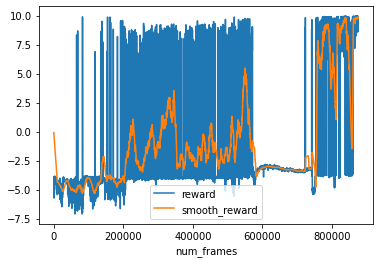

In [894]:
args = Config(use_critic=True, use_gae=True)
df_ppo, exps = run_experiment(args, update_parameters_ppo, env_param)
df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])


Solved!


<Axes: xlabel='num_frames'>

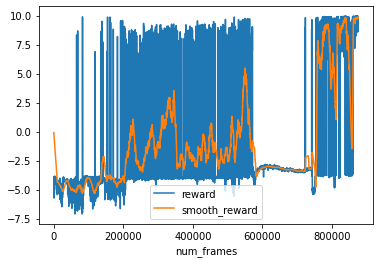

In [867]:
args = Config(use_critic=True, use_gae=True)
df_ppo, exps = run_experiment(args, update_parameters_ppo, env_param)
df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])

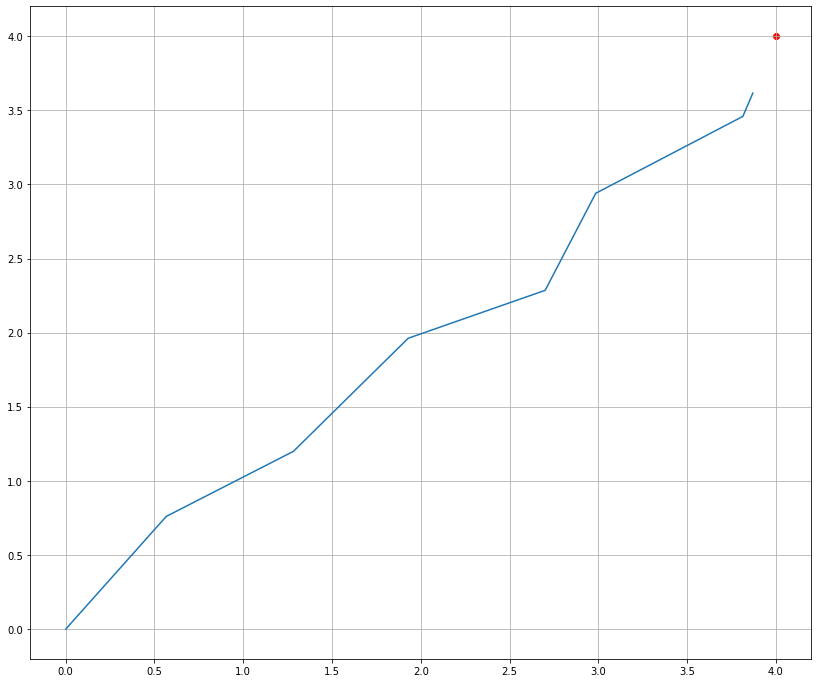

In [871]:
import matplotlib.pyplot as plt
x = exps[-1]["obs"][:, 0]
y = exps[-1]["obs"][:, 1]
theta = exps[-1]["obs"][:, 3]
fig = plt.figure(figsize = (14, 12))
plt.grid(True)
plt.scatter([4], [4], marker = "o", color = "r")
plt.plot(x, y)

#plt.quiver([x, y],[np.sin(t) for t in theta], [np.cos(t) for t in theta])
plt.show()

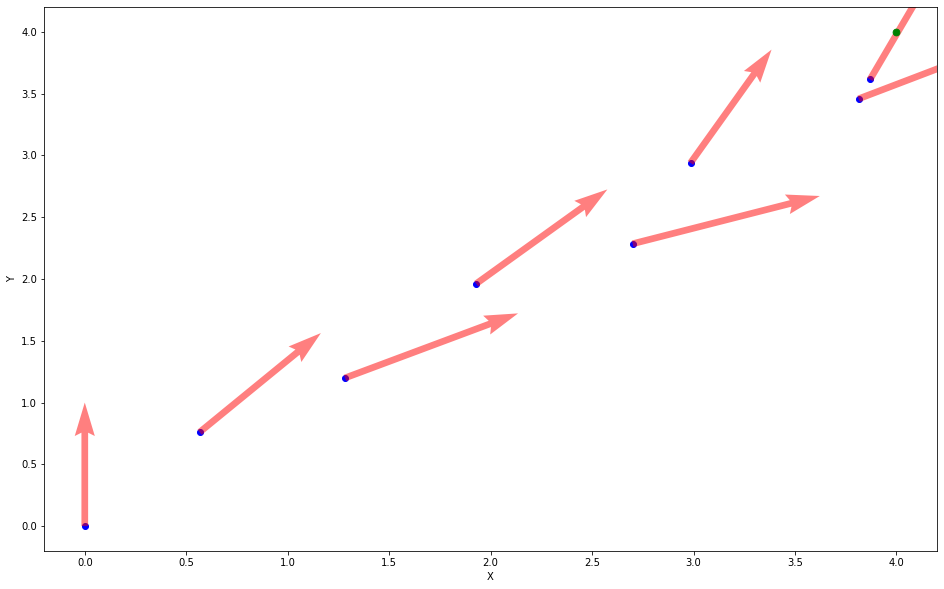

In [895]:

plot_points_with_vectors(x, y, theta)

In [822]:
theta[35]

tensor(2.0242)


Solved!


<Axes: xlabel='num_frames'>

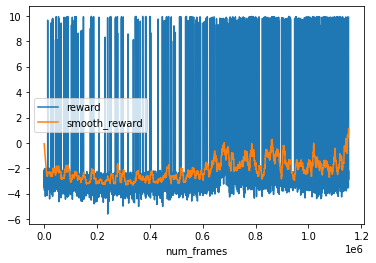

In [791]:
args = Config(use_critic=True, use_gae=True)
df_ppo, exps = run_experiment(args, update_parameters_ppo, env_param)
df_ppo.plot(x='num_frames', y=['reward', 'smooth_reward'])


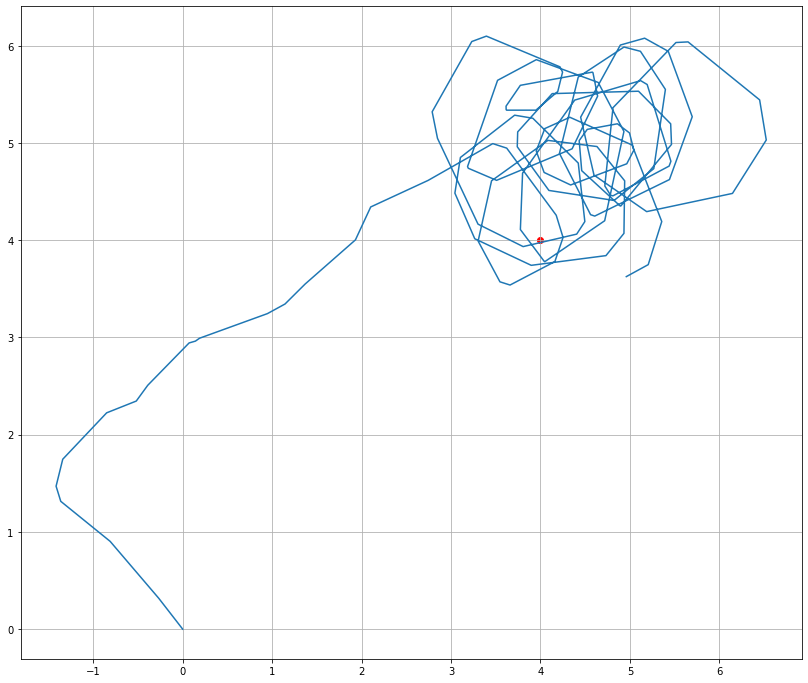

In [795]:
import matplotlib.pyplot as plt
x = exps[-8]["obs"][:, 0]
y = exps[-8]["obs"][:, 1]
theta = exps[-10]["obs"][:, 3]
fig = plt.figure(figsize = (14, 12))
plt.grid(True)
plt.scatter([4], [4], marker = "o", color = "r")
plt.plot(x, y)
#plt.quiver([x, y],[np.sin(t) for t in theta], [np.cos(t) for t in theta])
plt.show()

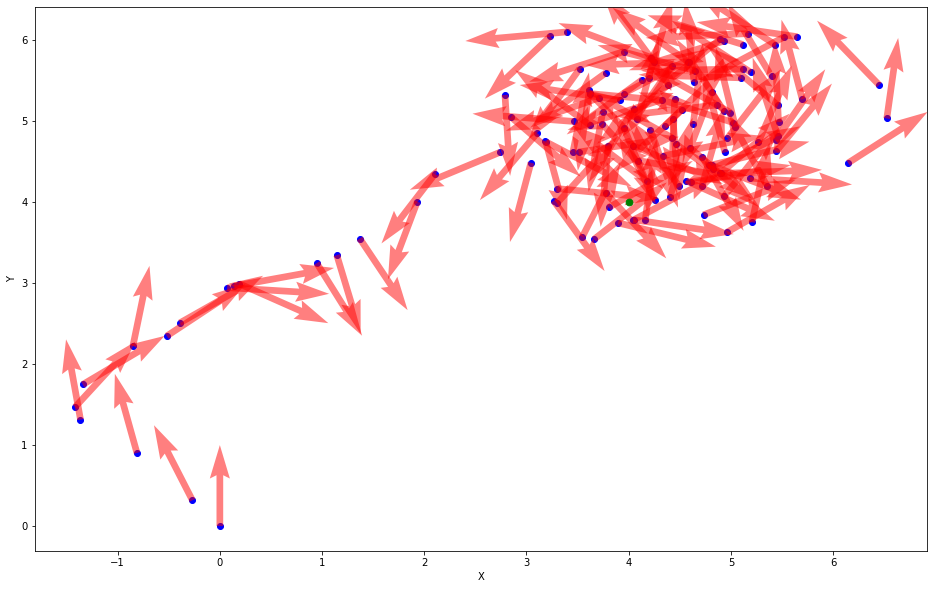

In [796]:
def plot_points_with_vectors(x_coords, y_coords, angles):
    fig, ax = plt.subplots(figsize = (16, 10))
    
    # Tracer les points
    ax.scatter(x_coords, y_coords, color='blue', label='Points')

    # Tracer les vecteurs
    for x, y, angle in zip(x_coords, y_coords, angles):
        vector_length = 1  # Longueur du vecteur
        dx = vector_length * np.sin(angle)  # Composante x du vecteur
        dy = vector_length * np.cos(angle)  # Composante y du vecteur
        ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='red', headwidth = 3, alpha = 0.5 , label='Vectors')
    plt.scatter([4], [4], marker = "o", color = "g", s = 45)
    #ax.set_aspect('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.legend()
    plt.show()

plot_points_with_vectors(x, y, theta)